- SARIMAX

In [1]:
import pandas as pd
from sklearn.base import TransformerMixin
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from os import mkdir
from os.path import isdir
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import SARIMAX

from utils.metrics import smape, mase, mis, coverage

import warnings
warnings.simplefilter('ignore')


In [2]:
#url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv' # get latest data

#df = pd.read_csv(url)
#print(df.to_string())

In [3]:
data_path = 'data/owid-covid-data.csv'
df = pd.read_csv(data_path)

In [4]:
df.tail()

,Unnamed: 0,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
104336,104336,ZWE,Africa,Zimbabwe,2021-07-18,83619.0,1006.0,2264.857,2622.0,34.0,...,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN
104337,104337,ZWE,Africa,Zimbabwe,2021-07-19,85732.0,2113.0,2186.571,2697.0,75.0,...,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN
104338,104338,ZWE,Africa,Zimbabwe,2021-07-20,88415.0,2683.0,2163.429,2747.0,50.0,...,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN
104339,104339,ZWE,Africa,Zimbabwe,2021-07-21,91120.0,2705.0,2105.571,2809.0,62.0,...,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN
104340,104340,ZWE,Africa,Zimbabwe,2021-07-22,93421.0,2301.0,2078.429,2870.0,61.0,...,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN


In [5]:
print(df.location.unique())
df = df[df.location.str.contains('United Kingdom')] # select a country to model

['Afghanistan' 'Africa' 'Albania' 'Algeria' 'Andorra' 'Angola' 'Anguilla'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba' 'Asia' 'Australia'
 'Austria' 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados'
 'Belarus' 'Belgium' 'Belize' 'Benin' 'Bermuda' 'Bhutan' 'Bolivia'
 'Bonaire Sint Eustatius and Saba' 'Bosnia and Herzegovina' 'Botswana'
 'Brazil' 'British Virgin Islands' 'Brunei' 'Bulgaria' 'Burkina Faso'
 'Burundi' 'Cambodia' 'Cameroon' 'Canada' 'Cape Verde' 'Cayman Islands'
 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia' 'Comoros'
 'Congo' 'Cook Islands' 'Costa Rica' "Cote d'Ivoire" 'Croatia' 'Cuba'
 'Curacao' 'Cyprus' 'Czechia' 'Democratic Republic of Congo' 'Denmark'
 'Djibouti' 'Dominica' 'Dominican Republic' 'Ecuador' 'Egypt'
 'El Salvador' 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Eswatini'
 'Ethiopia' 'Europe' 'European Union' 'Faeroe Islands' 'Falkland Islands'
 'Fiji' 'Finland' 'France' 'French Polynesia' 'Gabon' 'Gambia' 'Georgia'
 'Germany' 'Ghana'

In [6]:
# only use raw data
regex = ['smooth', 'new', 'per', 'tests_units', 'Unnamed: 0']
for ex in regex:
    df = df[df.columns.drop(list(df.filter(regex=ex)))]

In [7]:
#df.columns.to_list()

In [8]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("The dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

missing_values_table(df)

The dataframe has 31 columns.
There are 14 columns that have missing values.


,Missing Values,% of Total Values
weekly_icu_admissions,539,100.0
handwashing_facilities,539,100.0
weekly_hosp_admissions,471,87.4
excess_mortality,464,86.1
people_fully_vaccinated,346,64.2
total_vaccinations,342,63.5
people_vaccinated,342,63.5
positive_rate,68,12.6
icu_patients,64,11.9
total_tests,61,11.3


In [9]:
# drop columns >40% NaN
df = df.dropna(thresh=df.shape[0]*0.6,how='all',axis=1)
missing_values_table(df)

The dataframe has 24 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
positive_rate,68,12.6
icu_patients,64,11.9
total_tests,61,11.3
hosp_patients,58,10.8
total_deaths,35,6.5
reproduction_rate,33,6.1
stringency_index,3,0.6


In [10]:
# impute categorical missing values

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c] for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)


df = DataFrameImputer().fit_transform(df)

num_cols = df._get_numeric_data().columns


imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(df[num_cols])
IterativeImputer(random_state=0)
df[num_cols] = imp.transform(df[num_cols])



missing_values_table(df)

The dataframe has 24 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [11]:
# use date as index

regex = ['iso_code', 'continent', 'location']
for ex in regex:
    df = df[df.columns.drop(list(df.filter(regex=ex)))]
    
#df['key'] = df['date']


df.set_index(keys = 'date', drop = True, append = False, inplace = True)
df.index.name = None

print(df.shape) # print the number of rows and columns
df

(539, 20)


,total_cases,total_deaths,reproduction_rate,icu_patients,hosp_patients,total_tests,positive_rate,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,life_expectancy,human_development_index
2020-01-31,2.0,22040.634234,2.085690,1349.601954,12262.494291,2.323071e+06,0.065577,8.330000,67886004.0,272.898,40.8,18.517,12.527,0.2,122.137,4.28,20.0,24.7,81.32,0.932
2020-02-01,2.0,22040.634234,2.085690,1349.601954,12262.494291,2.323071e+06,0.065577,8.330000,67886004.0,272.898,40.8,18.517,12.527,0.2,122.137,4.28,20.0,24.7,81.32,0.932
2020-02-02,2.0,22083.110857,2.047862,1346.385663,12232.362774,2.274868e+06,0.067284,11.110000,67886004.0,272.898,40.8,18.517,12.527,0.2,122.137,4.28,20.0,24.7,81.32,0.932
2020-02-03,8.0,22083.250328,2.047862,1346.385231,12232.358838,2.275055e+06,0.067284,11.110000,67886004.0,272.898,40.8,18.517,12.527,0.2,122.137,4.28,20.0,24.7,81.32,0.932
2020-02-04,8.0,22083.250328,2.047862,1346.385231,12232.358838,2.275055e+06,0.067284,11.110000,67886004.0,272.898,40.8,18.517,12.527,0.2,122.137,4.28,20.0,24.7,81.32,0.932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-18,5455276.0,128988.000000,1.300000,582.000000,4297.000000,2.290325e+08,0.041000,51.390000,67886004.0,272.898,40.8,18.517,12.527,0.2,122.137,4.28,20.0,24.7,81.32,0.932
2021-07-19,5495947.0,129007.000000,1.240000,611.000000,4599.000000,2.302727e+08,0.041000,43.980000,67886004.0,272.898,40.8,18.517,12.527,0.2,122.137,4.28,20.0,24.7,81.32,0.932
2021-07-20,5542635.0,129109.000000,1.190000,618.000000,4658.000000,2.312178e+08,0.043000,36.624600,67886004.0,272.898,40.8,18.517,12.527,0.2,122.137,4.28,20.0,24.7,81.32,0.932
2021-07-21,5586716.0,129182.000000,1.160000,1567.052626,13104.830377,2.323031e+08,0.044000,40.421521,67886004.0,272.898,40.8,18.517,12.527,0.2,122.137,4.28,20.0,24.7,81.32,0.932


In [12]:
#plt.figure(figsize=(50,4))
#plt.plot(range(len(df)),df[y_col]);

In [13]:
# scale df

feature_range = (1, 2)

df_scaler = MinMaxScaler(feature_range = feature_range) # scale so that entire df is strictly positive 
df_scaler.fit(df)

scaled_df = pd.DataFrame(df_scaler.transform(df), columns = df.columns)
print(scaled_df.shape)


(539, 20)


In [14]:
# split train & test for scaled_df

test_size = int(len(scaled_df) * 0.1) # the test data will be 10% (0.1) of the entire data
train = scaled_df.iloc[:-test_size,:].copy() 
# the copy() here is important, it will prevent us from getting: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame. Try using .loc[row_index,col_indexer] = value instead
test = scaled_df.iloc[-test_size:,:].copy()
print(train.shape, test.shape)


(486, 20) (53, 20)


In [15]:
# split x and y only for the train data

#y_col='total_deaths'
y_col=['total_deaths', 'total_cases'] # define y variable, i.e., what we want to predict

x_train = train.drop(y_col,axis=1).copy()
y_train = train[y_col].copy()
print(x_train.shape, y_train.shape)


(486, 18) (486, 2)


In [16]:
# split x for test

x_test = test.drop(y_col, axis=1).copy()
x_test.shape

(53, 18)

In [19]:
alpha = 0.05
y_pred_scaled = pd.DataFrame(columns = y_col)

for col in y_col:
    model = SARIMAX(endog = y_train[col], exog = x_train, enforce_invertibility = False)
    model_fit = model.fit(disp = False)
    print(model_fit.summary())
    model_forecast = model_fit.get_prediction(start = model.nobs, end = model.nobs + test.shape[0] - 1, exog = x_test)
    y_pred_scaled[col] = model_forecast.predicted_mean # forecast
    vars()['pi_' + col] = pd.DataFrame()
    vars()['pi_' + col] = model_forecast.conf_int() # prediction intervals

                               SARIMAX Results                                
Dep. Variable:           total_deaths   No. Observations:                  486
Model:               SARIMAX(1, 0, 0)   Log Likelihood                1678.004
Date:                Tue, 10 Aug 2021   AIC                          -3316.009
Time:                        13:56:29   BIC                          -3232.285
Sample:                             0   HQIC                         -3283.116
                                - 486                                         
Covariance Type:                  opg                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
reproduction_rate          -0.0493      0.017     -2.934      0.003      -0.082      -0.016
icu_patients                0.6106      0.027     22.762      0.000       0.558       0.663


In [20]:
model_forecast.conf_int().index

RangeIndex(start=486, stop=539, step=1)

In [23]:
# descale

placehold_df = df.copy()
placehold_df[y_col[0]][-y_pred_scaled.shape[0]:] = y_pred_scaled.iloc[:, 0]
placehold_df[y_col[1]][-y_pred_scaled.shape[0]:] = y_pred_scaled.iloc[:, 1]
placehold_df = pd.DataFrame(df_scaler.inverse_transform(placehold_df), columns = placehold_df.columns)
y_pred = placehold_df[y_col][-y_pred_scaled.shape[0]:]

# descale lower

placehold_df = df.copy()
placehold_df[y_col[0]][-y_pred_scaled.shape[0]:] = pi_total_deaths.iloc[:, 0]
placehold_df[y_col[1]][-y_pred_scaled.shape[0]:] = pi_total_cases.iloc[:, 0]
placehold_df = pd.DataFrame(df_scaler.inverse_transform(placehold_df), columns = placehold_df.columns)
lower = placehold_df[y_col][-y_pred_scaled.shape[0]:]
lower.columns = [pi_total_deaths.columns[0], pi_total_cases.columns[0]]

# descale upper

placehold_df = df.copy()
placehold_df[y_col[0]][-y_pred_scaled.shape[0]:] = pi_total_deaths.iloc[:, 1]
placehold_df[y_col[1]][-y_pred_scaled.shape[0]:] = pi_total_cases.iloc[:, 1]
placehold_df = pd.DataFrame(df_scaler.inverse_transform(placehold_df), columns = placehold_df.columns)
upper = placehold_df[y_col][-y_pred_scaled.shape[0]:]
upper.columns = [pi_total_deaths.columns[1], pi_total_cases.columns[1]]


In [24]:
# prune results

results = pd.DataFrame({'y_true0':df[y_col[0]][-y_pred_scaled.shape[0]:].values,
                        'y_true1':df[y_col[1]][-y_pred_scaled.shape[0]:].values,
                        'y_pred0':y_pred.iloc[:, 0], 'y_pred1':y_pred.iloc[:, 1]})
print(results.shape)

test_size = 0.75
_, results = train_test_split(results, test_size = test_size, shuffle = False)
print(results.shape)

n_input_train = 14 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
results = results.iloc[n_input_train:, :]
print(results.shape)
print(results)

# prune lower

_, lower = train_test_split(lower, test_size = test_size, shuffle = False)
print(lower.shape)

lower = lower.iloc[n_input_train:, :]
print(lower.shape)

# prune lower

_, upper = train_test_split(upper, test_size = test_size, shuffle = False)
print(upper.shape)

upper = upper.iloc[n_input_train:, :]
print(upper.shape)

(53, 4)
(40, 4)
(26, 4)
      y_true0    y_true1        y_pred0       y_pred1
513  128364.0  4748644.0  126411.818545  4.518603e+06
514  128367.0  4771367.0  126341.108374  4.532014e+06
515  128390.0  4791628.0  125911.093515  4.518255e+06
516  128404.0  4817298.0  125727.127587  4.512808e+06
517  128426.0  4844944.0  125675.193103  4.509809e+06
518  128453.0  4871807.0  125833.370335  4.511166e+06
519  128471.0  4896272.0  125752.004557  4.503851e+06
520  128486.0  4920168.0  125542.245183  4.501418e+06
521  128495.0  4947274.0  125697.293118  4.508624e+06
522  128532.0  4975903.0  125747.567297  4.512590e+06
523  128565.0  5007964.0  125926.467105  4.516433e+06
524  128601.0  5040060.0  125641.023594  4.508103e+06
525  128631.0  5075945.0  125493.245482  4.509514e+06
526  128665.0  5107780.0  125351.775979  4.506338e+06
527  128691.0  5139162.0  124962.645523  4.503047e+06
528  128697.0  5173972.0  124603.876267  4.503293e+06
529  128747.0  5210472.0  124764.920044  4.514687e+06
530 

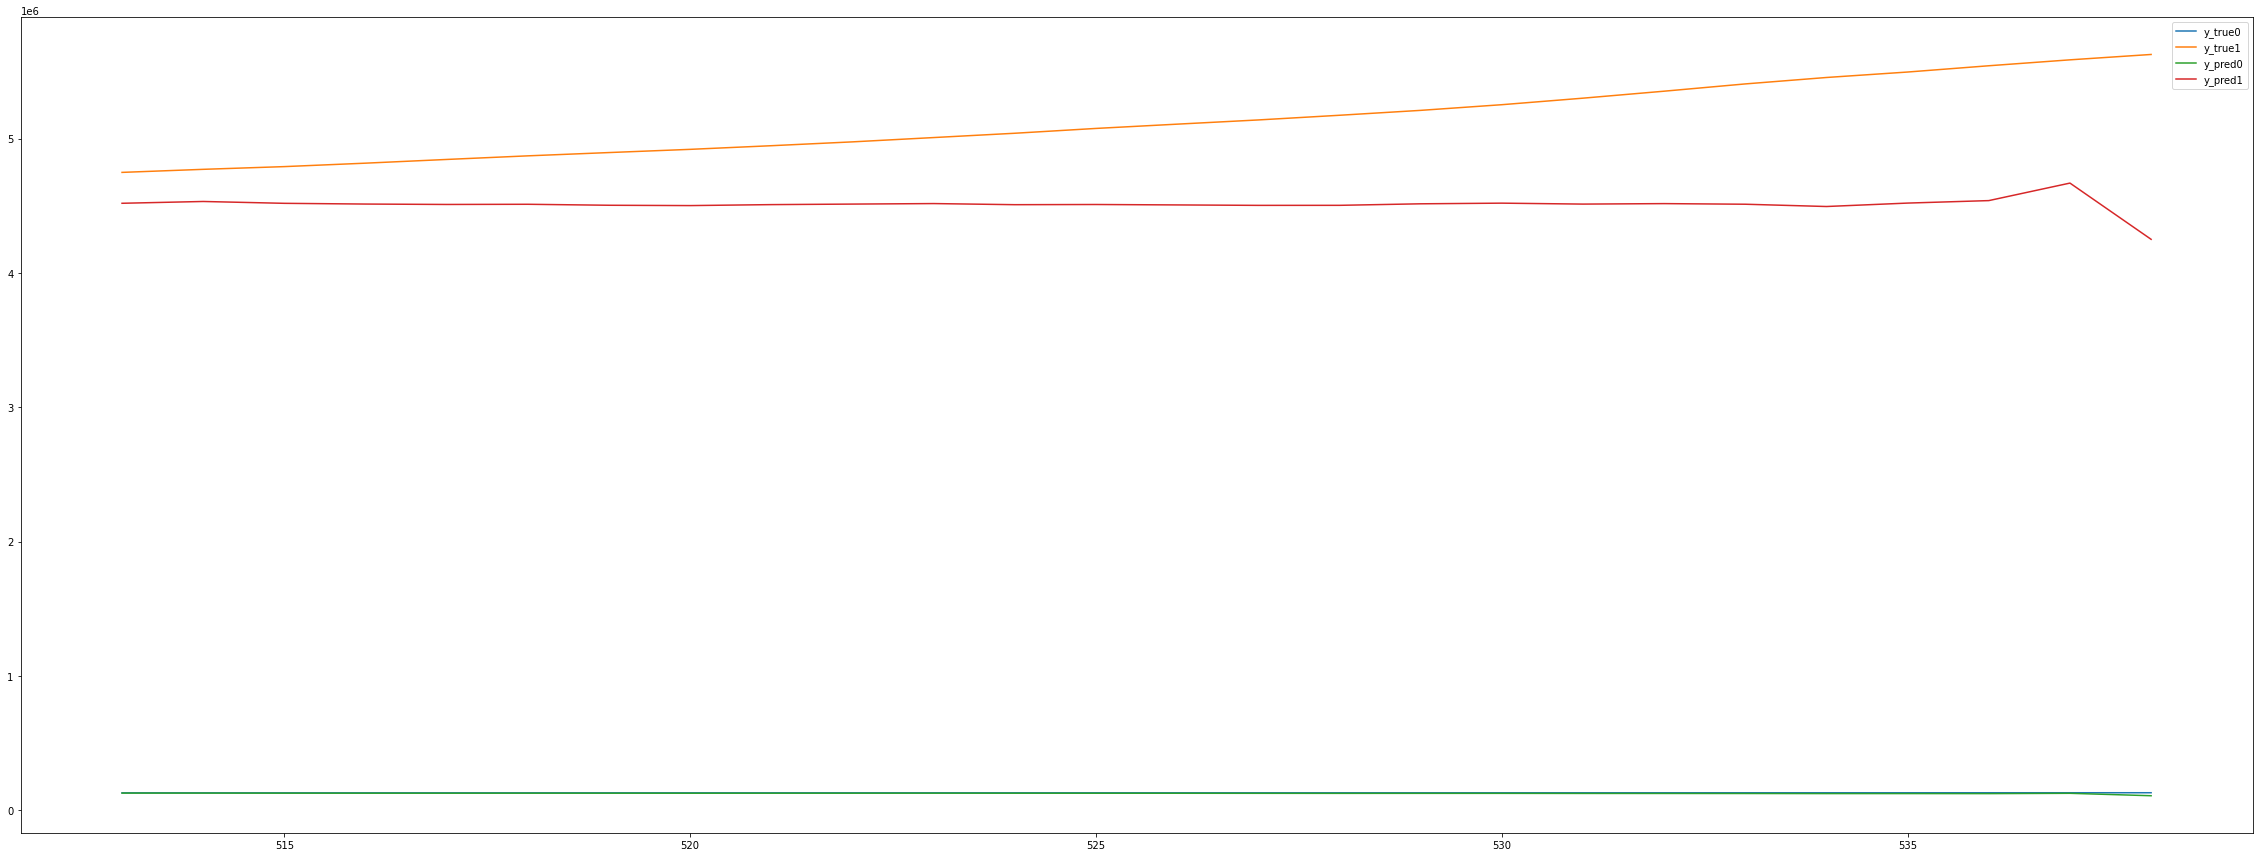

In [25]:
results.plot(figsize = (40, 15))

In [26]:
def smape(y, y_hat):
    tmp = 2 * np.abs(y_hat - y) / (np.abs(y) + np.abs(y_hat))
    len_ = np.count_nonzero(~np.isnan(tmp))
    if len_ == 0 and np.nansum(tmp) == 0: # Deals with a special case
        return 100
    return 100 / len_ * np.nansum(tmp)

print(smape(results.iloc[:, 0], results.iloc[:, 2]))
print(smape(results.iloc[:, 1], results.iloc[:, 3]))

3.507698089507064
12.746224530525785


In [27]:
print(mase(train, results.iloc[:, 0], results.iloc[:, 2]))
print(mase(train, results.iloc[:, 1], results.iloc[:, 3]))

1591.5505232099679
225504.57013995122


In [28]:
print(mis(lower.iloc[:, 0].values, upper.iloc[:, 0].values, results.iloc[:, 0].values, alpha = alpha))
print(mis(lower.iloc[:, 1].values, upper.iloc[:, 1].values, results.iloc[:, 1].values, alpha = alpha))

37849.61362760767
12201874.322505202


In [29]:
print(coverage(lower.iloc[:, 0].values, upper.iloc[:, 0].values, results.iloc[:, 0].values))
print(coverage(lower.iloc[:, 1].values, upper.iloc[:, 1].values, results.iloc[:, 1].values))

96.15384615384616
15.384615384615385


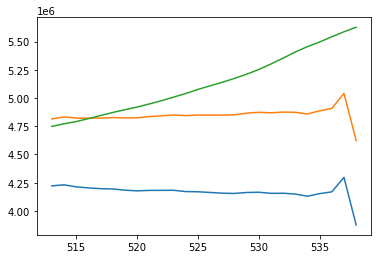

In [30]:
import matplotlib
matplotlib.pyplot.plot(lower.iloc[:, 1])
matplotlib.pyplot.plot(upper.iloc[:, 1])
matplotlib.pyplot.plot(results.iloc[:, 1])